In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [88]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [89]:
root_folder = 'FC_VAE_results'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(recon_folder)

In [90]:
mnist_sigmoid = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                lambda x: x.to(device)
           ])

In [91]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_sigmoid)
fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_x, _ = next(iter(test_loader))
fixed_x = fixed_x[:100].to(device)

cuda:0


In [92]:
data, label = next(iter(train_loader))

In [93]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [94]:
class VAE(nn.Module):
    def __init__(self, latent_size=32, bn=False, lr=0.0001):
        super(VAE, self).__init__()
        self.encoder = FullyConnected([28*28, 1024, 1024, latent_size*2], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
        self.decoder = FullyConnected([latent_size, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), device=device)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.name = 'VAE' + str(latent_size)
   
    def get_name(self):
        return self.name

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)  # mean and log variance.
        z = self.reparameterize(mu, logvar)
        out = self.decoder(z)
        return out, mu, logvar

    def loss(self, recon_x, x, mu, logvar):
        #print ('recon_x',recon_x)
        #print ('x',x)
        recon_x = torch.sigmoid(recon_x)
        x = torch.sigmoid(x)
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
        #print ('BCE=',BCE)

        KLD = 0.5 * torch.sum(logvar.exp() + mu * mu - 1 - logvar)
        #print ('KLD=',KLD)

        return BCE + KLD

In [95]:
batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

In [96]:
def train(model, epoch, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        model.optimizer.zero_grad()
        reconstructed, mu, logvar = model(data)
        loss = model.loss(reconstructed, data, mu, logvar)
        loss.backward()
        
        model.optimizer.step()
        
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = model.get_name() + ': {:.4f}'.format(loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = model.get_name() + ': {:.4f}'.format(loss.item())
        print(line + losses)
        if log is not None:
            log[model.get_name()].append((loss.item(),))

In [97]:
def test(model, loader, epoch, full_recon_folder, log=None):
    test_size = len(loader)
    test_loss[model.get_name()] = 0.
    with torch.no_grad():
        for data, _ in loader:
            reconstructed, mu, logvar = model(data)
            loss = model.loss(reconstructed, data, mu, logvar)
            test_loss[model.get_name()] += loss.item()
            
        test_loss[model.get_name()] /= test_size

        reconstruction, _, _ = model(fixed_x)
        reconstruction = reconstruction.cpu().data.numpy().reshape(-1, 1, 28, 28)
        if epoch % 10 == 0:
            plot_mnist(reconstruction, (10, 10), True, full_recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. {}: {:.4f}'.format(model.get_name(), test_loss[model.get_name()])
    print(report)
    if log is not None:
        log[model.get_name()].append((test_loss[model.get_name()],))

In [98]:
models = {'VAE2': VAE(2),
          'VAE32': VAE(32), 
          'VAE64': VAE(64)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [99]:
test_loss = {k: 0.0 for k in models}

Train Epoch: 1 [0/50000 (0%)]	Losses VAE2: 136261.1875
Train Epoch: 1 [25000/50000 (50%)]	Losses VAE2: 130972.5703
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE2: 130321.0781
Test losses. VAE2: 130328.4318
Train Epoch: 2 [0/50000 (0%)]	Losses VAE2: 130119.1328
Train Epoch: 2 [25000/50000 (50%)]	Losses VAE2: 130363.3281
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE2: 130093.7734
Test losses. VAE2: 130041.5488
Train Epoch: 3 [0/50000 (0%)]	Losses VAE2: 129774.2656
Train Epoch: 3 [25000/50000 (50%)]	Losses VAE2: 130176.7188
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE2: 129904.0625
Test losses. VAE2: 129890.7156
Train Epoch: 4 [0/50000 (0%)]	Losses VAE2: 129808.0859
Train Epoch: 4 [25000/50000 (50%)]	Losses VAE2: 129973.7266
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE2: 129977.5859
Test losses. VAE2: 129788.2719
Train Epoch: 5 [0/50000 (0%)]	Losses VAE2: 129631.8438
Train Epoch: 5 [25000/50000 (50%)]	Losses VAE2: 129321.9688
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE2: 129782.2

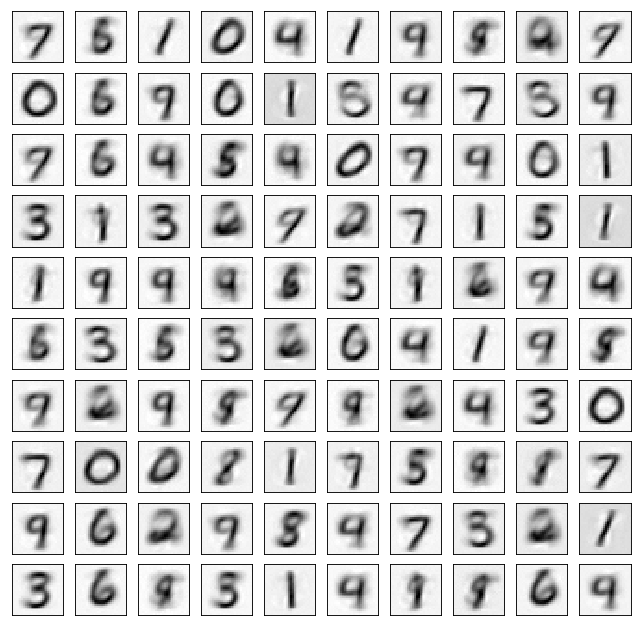

Test losses. VAE2: 129453.5594
Train Epoch: 11 [0/50000 (0%)]	Losses VAE2: 128929.2188
Train Epoch: 11 [25000/50000 (50%)]	Losses VAE2: 129566.3359
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE2: 129791.4141
Test losses. VAE2: 129427.0064
Train Epoch: 12 [0/50000 (0%)]	Losses VAE2: 129204.9375
Train Epoch: 12 [25000/50000 (50%)]	Losses VAE2: 129629.7188
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE2: 129372.0156
Test losses. VAE2: 129400.8938
Train Epoch: 13 [0/50000 (0%)]	Losses VAE2: 129257.4766
Train Epoch: 13 [25000/50000 (50%)]	Losses VAE2: 129420.3359
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE2: 129519.6328
Test losses. VAE2: 129335.1652
Train Epoch: 14 [0/50000 (0%)]	Losses VAE2: 129648.4531
Train Epoch: 14 [25000/50000 (50%)]	Losses VAE2: 129354.9141
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE2: 129168.1172
Test losses. VAE2: 129335.0289
Train Epoch: 15 [0/50000 (0%)]	Losses VAE2: 129543.1562
Train Epoch: 15 [25000/50000 (50%)]	Losses VAE2: 129369.5781
Train Epoch:

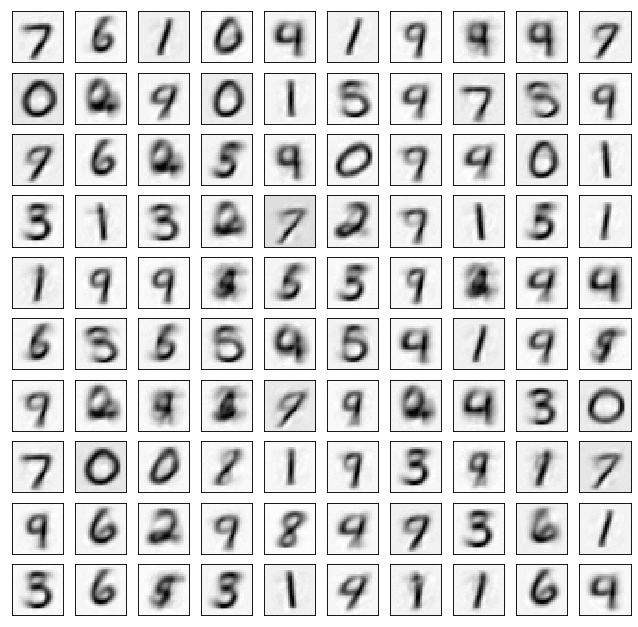

Test losses. VAE2: 129193.6041
Train Epoch: 21 [0/50000 (0%)]	Losses VAE2: 128872.8359
Train Epoch: 21 [25000/50000 (50%)]	Losses VAE2: 129053.1797
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE2: 129501.9219
Test losses. VAE2: 129185.6664
Train Epoch: 22 [0/50000 (0%)]	Losses VAE2: 129124.7500
Train Epoch: 22 [25000/50000 (50%)]	Losses VAE2: 129552.9688
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE2: 129087.0156
Test losses. VAE2: 129166.7396
Train Epoch: 23 [0/50000 (0%)]	Losses VAE2: 129423.5781
Train Epoch: 23 [25000/50000 (50%)]	Losses VAE2: 128706.2266
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE2: 129017.9062
Test losses. VAE2: 129157.7770
Train Epoch: 24 [0/50000 (0%)]	Losses VAE2: 129384.1484
Train Epoch: 24 [25000/50000 (50%)]	Losses VAE2: 129110.8672
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE2: 128953.5938
Test losses. VAE2: 129142.4998
Train Epoch: 25 [0/50000 (0%)]	Losses VAE2: 129330.7812
Train Epoch: 25 [25000/50000 (50%)]	Losses VAE2: 128926.9375
Train Epoch:

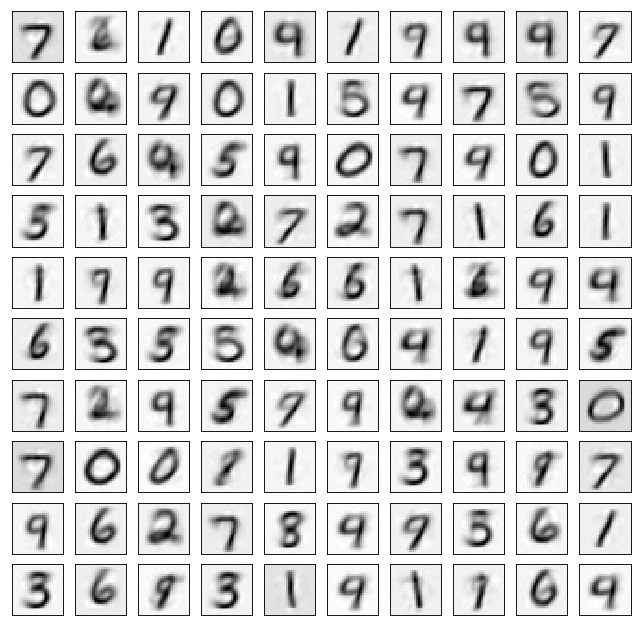

Test losses. VAE2: 129075.7613
Train Epoch: 31 [0/50000 (0%)]	Losses VAE2: 128928.0391
Train Epoch: 31 [25000/50000 (50%)]	Losses VAE2: 128878.5547
Train Epoch: 31 [50000/50000 (100%)]	Losses VAE2: 129031.8750
Test losses. VAE2: 129076.4885
Train Epoch: 32 [0/50000 (0%)]	Losses VAE2: 129292.2031
Train Epoch: 32 [25000/50000 (50%)]	Losses VAE2: 128933.3750
Train Epoch: 32 [50000/50000 (100%)]	Losses VAE2: 129298.5312
Test losses. VAE2: 129048.3008
Train Epoch: 33 [0/50000 (0%)]	Losses VAE2: 129194.6172
Train Epoch: 33 [25000/50000 (50%)]	Losses VAE2: 128675.9609
Train Epoch: 33 [50000/50000 (100%)]	Losses VAE2: 129188.8359
Test losses. VAE2: 129052.6803
Train Epoch: 34 [0/50000 (0%)]	Losses VAE2: 128984.1250
Train Epoch: 34 [25000/50000 (50%)]	Losses VAE2: 128659.1328
Train Epoch: 34 [50000/50000 (100%)]	Losses VAE2: 129069.0547
Test losses. VAE2: 129042.9662
Train Epoch: 35 [0/50000 (0%)]	Losses VAE2: 128834.1953
Train Epoch: 35 [25000/50000 (50%)]	Losses VAE2: 128738.1250
Train Epoch:

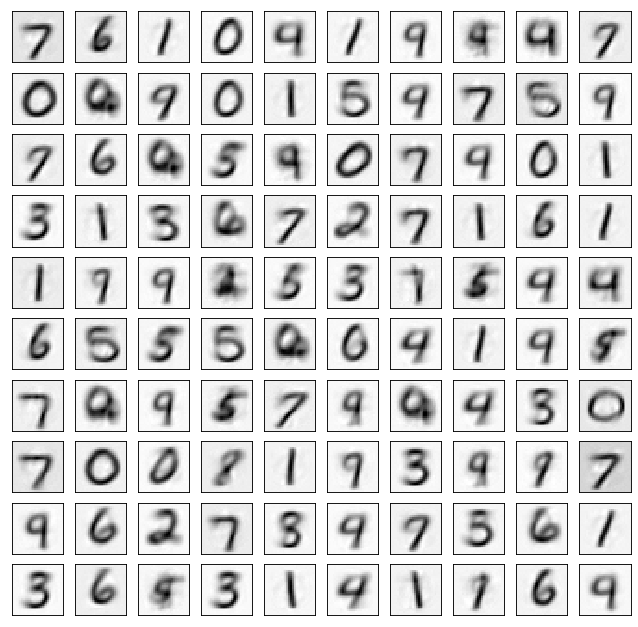

Test losses. VAE2: 129030.0850
Train Epoch: 41 [0/50000 (0%)]	Losses VAE2: 128686.9922
Train Epoch: 41 [25000/50000 (50%)]	Losses VAE2: 129055.1562
Train Epoch: 41 [50000/50000 (100%)]	Losses VAE2: 128736.7266
Test losses. VAE2: 129017.6213
Train Epoch: 42 [0/50000 (0%)]	Losses VAE2: 128969.7891
Train Epoch: 42 [25000/50000 (50%)]	Losses VAE2: 128914.4766
Train Epoch: 42 [50000/50000 (100%)]	Losses VAE2: 128677.8516
Test losses. VAE2: 129007.6602
Train Epoch: 43 [0/50000 (0%)]	Losses VAE2: 128862.7969
Train Epoch: 43 [25000/50000 (50%)]	Losses VAE2: 128477.0781
Train Epoch: 43 [50000/50000 (100%)]	Losses VAE2: 129048.3984
Test losses. VAE2: 128986.5871
Train Epoch: 44 [0/50000 (0%)]	Losses VAE2: 129186.6953
Train Epoch: 44 [25000/50000 (50%)]	Losses VAE2: 128816.6641
Train Epoch: 44 [50000/50000 (100%)]	Losses VAE2: 128785.9219
Test losses. VAE2: 128985.1637
Train Epoch: 45 [0/50000 (0%)]	Losses VAE2: 128894.3828
Train Epoch: 45 [25000/50000 (50%)]	Losses VAE2: 128866.5078
Train Epoch:

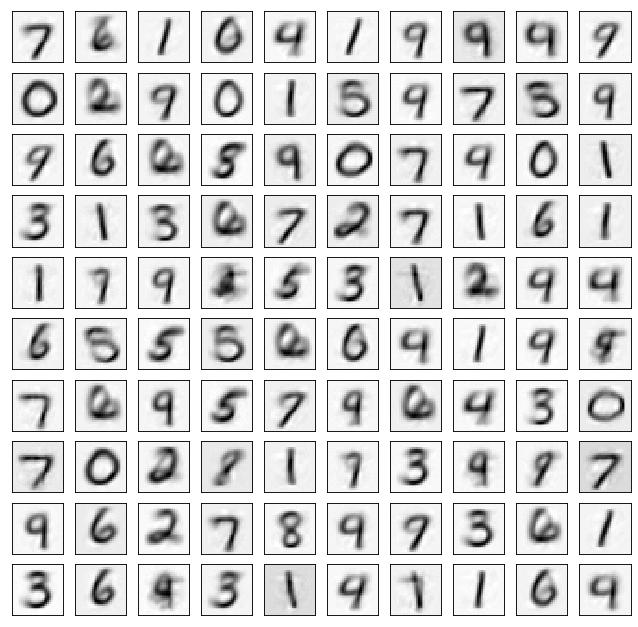

Test losses. VAE2: 128950.9971
Train Epoch: 51 [0/50000 (0%)]	Losses VAE2: 129065.4062
Train Epoch: 51 [25000/50000 (50%)]	Losses VAE2: 128914.4766
Train Epoch: 51 [50000/50000 (100%)]	Losses VAE2: 128596.8047
Test losses. VAE2: 128940.7164
Train Epoch: 52 [0/50000 (0%)]	Losses VAE2: 128837.6328
Train Epoch: 52 [25000/50000 (50%)]	Losses VAE2: 128755.3281
Train Epoch: 52 [50000/50000 (100%)]	Losses VAE2: 128899.1016
Test losses. VAE2: 128976.3570
Train Epoch: 53 [0/50000 (0%)]	Losses VAE2: 128583.2656
Train Epoch: 53 [25000/50000 (50%)]	Losses VAE2: 128747.3984
Train Epoch: 53 [50000/50000 (100%)]	Losses VAE2: 128841.2500
Test losses. VAE2: 128938.7688
Train Epoch: 54 [0/50000 (0%)]	Losses VAE2: 128540.5156
Train Epoch: 54 [25000/50000 (50%)]	Losses VAE2: 128844.8750
Train Epoch: 54 [50000/50000 (100%)]	Losses VAE2: 128652.4844
Test losses. VAE2: 128922.7486
Train Epoch: 55 [0/50000 (0%)]	Losses VAE2: 128531.4375
Train Epoch: 55 [25000/50000 (50%)]	Losses VAE2: 128759.8984
Train Epoch:

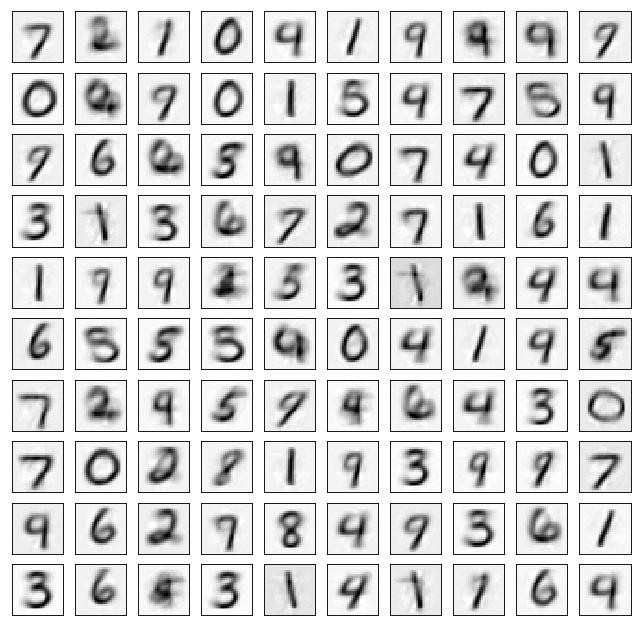

Test losses. VAE2: 128908.8736
Train Epoch: 61 [0/50000 (0%)]	Losses VAE2: 129035.4375
Train Epoch: 61 [25000/50000 (50%)]	Losses VAE2: 128305.9531
Train Epoch: 61 [50000/50000 (100%)]	Losses VAE2: 128632.8281
Test losses. VAE2: 128931.1543
Train Epoch: 62 [0/50000 (0%)]	Losses VAE2: 128939.9766
Train Epoch: 62 [25000/50000 (50%)]	Losses VAE2: 129034.6797
Train Epoch: 62 [50000/50000 (100%)]	Losses VAE2: 128807.0547
Test losses. VAE2: 128901.5012
Train Epoch: 63 [0/50000 (0%)]	Losses VAE2: 128904.1016
Train Epoch: 63 [25000/50000 (50%)]	Losses VAE2: 128672.9453
Train Epoch: 63 [50000/50000 (100%)]	Losses VAE2: 128636.3438
Test losses. VAE2: 128903.3924
Train Epoch: 64 [0/50000 (0%)]	Losses VAE2: 128594.3750
Train Epoch: 64 [25000/50000 (50%)]	Losses VAE2: 128624.2266
Train Epoch: 64 [50000/50000 (100%)]	Losses VAE2: 128958.2891
Test losses. VAE2: 128914.2057
Train Epoch: 65 [0/50000 (0%)]	Losses VAE2: 128621.4141
Train Epoch: 65 [25000/50000 (50%)]	Losses VAE2: 128691.1719
Train Epoch:

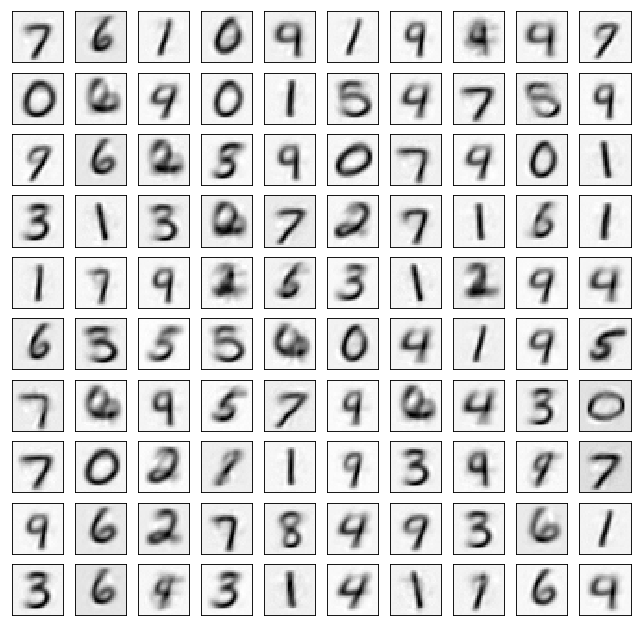

Test losses. VAE2: 128887.4980
Train Epoch: 71 [0/50000 (0%)]	Losses VAE2: 128545.3672
Train Epoch: 71 [25000/50000 (50%)]	Losses VAE2: 128524.2500
Train Epoch: 71 [50000/50000 (100%)]	Losses VAE2: 129001.7812
Test losses. VAE2: 128885.5982
Train Epoch: 72 [0/50000 (0%)]	Losses VAE2: 128839.0078
Train Epoch: 72 [25000/50000 (50%)]	Losses VAE2: 128643.0938
Train Epoch: 72 [50000/50000 (100%)]	Losses VAE2: 128570.8906
Test losses. VAE2: 128871.4943
Train Epoch: 73 [0/50000 (0%)]	Losses VAE2: 128671.7500
Train Epoch: 73 [25000/50000 (50%)]	Losses VAE2: 128900.4297
Train Epoch: 73 [50000/50000 (100%)]	Losses VAE2: 128374.8281
Test losses. VAE2: 128878.2684
Train Epoch: 74 [0/50000 (0%)]	Losses VAE2: 128115.0312
Train Epoch: 74 [25000/50000 (50%)]	Losses VAE2: 128674.8594
Train Epoch: 74 [50000/50000 (100%)]	Losses VAE2: 128831.7344
Test losses. VAE2: 128859.8924
Train Epoch: 75 [0/50000 (0%)]	Losses VAE2: 128986.3203
Train Epoch: 75 [25000/50000 (50%)]	Losses VAE2: 128787.4062
Train Epoch:

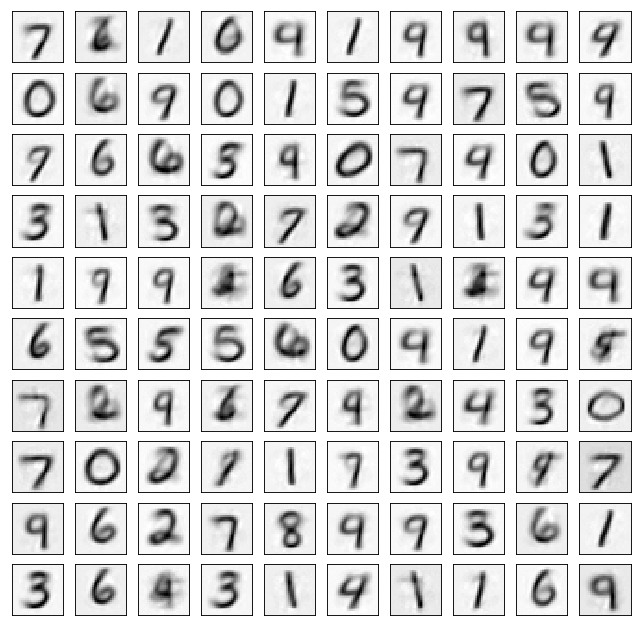

Test losses. VAE2: 128855.7619
Train Epoch: 81 [0/50000 (0%)]	Losses VAE2: 128845.9531
Train Epoch: 81 [25000/50000 (50%)]	Losses VAE2: 128618.5703
Train Epoch: 81 [50000/50000 (100%)]	Losses VAE2: 128934.2422
Test losses. VAE2: 128882.5229
Train Epoch: 82 [0/50000 (0%)]	Losses VAE2: 128924.7734
Train Epoch: 82 [25000/50000 (50%)]	Losses VAE2: 128977.9297
Train Epoch: 82 [50000/50000 (100%)]	Losses VAE2: 128764.9766
Test losses. VAE2: 128848.9881
Train Epoch: 83 [0/50000 (0%)]	Losses VAE2: 128862.0234
Train Epoch: 83 [25000/50000 (50%)]	Losses VAE2: 128940.0781
Train Epoch: 83 [50000/50000 (100%)]	Losses VAE2: 128779.1328
Test losses. VAE2: 128871.9988
Train Epoch: 84 [0/50000 (0%)]	Losses VAE2: 128730.5078
Train Epoch: 84 [25000/50000 (50%)]	Losses VAE2: 128567.6406
Train Epoch: 84 [50000/50000 (100%)]	Losses VAE2: 128383.0391
Test losses. VAE2: 128848.3633
Train Epoch: 85 [0/50000 (0%)]	Losses VAE2: 128668.1016
Train Epoch: 85 [25000/50000 (50%)]	Losses VAE2: 128679.5312
Train Epoch:

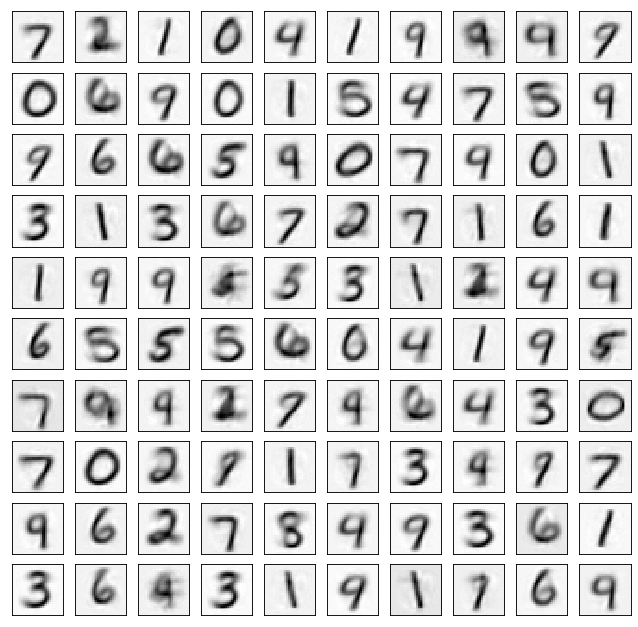

Test losses. VAE2: 128846.5068
Train Epoch: 91 [0/50000 (0%)]	Losses VAE2: 128596.1016
Train Epoch: 91 [25000/50000 (50%)]	Losses VAE2: 128610.3516
Train Epoch: 91 [50000/50000 (100%)]	Losses VAE2: 128779.4062
Test losses. VAE2: 128826.0289
Train Epoch: 92 [0/50000 (0%)]	Losses VAE2: 128288.7578
Train Epoch: 92 [25000/50000 (50%)]	Losses VAE2: 128263.3281
Train Epoch: 92 [50000/50000 (100%)]	Losses VAE2: 128729.1953
Test losses. VAE2: 128836.9607
Train Epoch: 93 [0/50000 (0%)]	Losses VAE2: 128515.7812
Train Epoch: 93 [25000/50000 (50%)]	Losses VAE2: 128904.4609
Train Epoch: 93 [50000/50000 (100%)]	Losses VAE2: 128292.1406
Test losses. VAE2: 128825.6281
Train Epoch: 94 [0/50000 (0%)]	Losses VAE2: 128651.1172
Train Epoch: 94 [25000/50000 (50%)]	Losses VAE2: 128709.2656
Train Epoch: 94 [50000/50000 (100%)]	Losses VAE2: 128496.2891
Test losses. VAE2: 128849.7039
Train Epoch: 95 [0/50000 (0%)]	Losses VAE2: 128822.7266
Train Epoch: 95 [25000/50000 (50%)]	Losses VAE2: 128538.0391
Train Epoch:

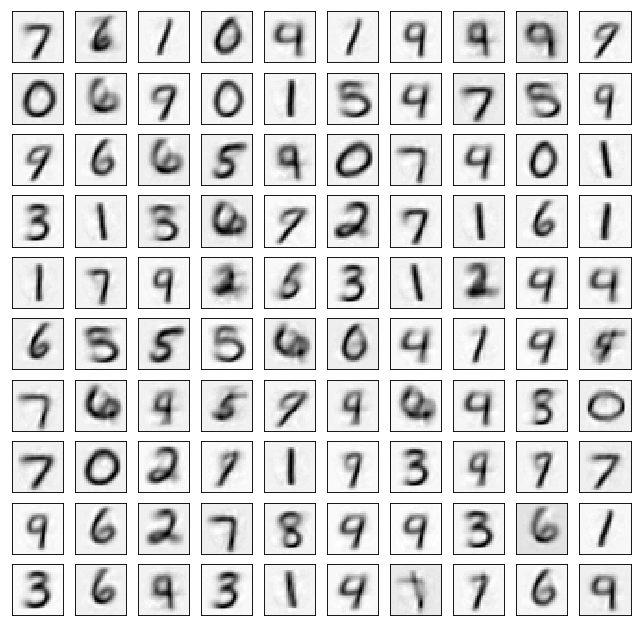

Test losses. VAE2: 128838.9025
Train Epoch: 1 [0/50000 (0%)]	Losses VAE32: 136198.1250
Train Epoch: 1 [25000/50000 (50%)]	Losses VAE32: 131740.8438
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE32: 130629.0391
Test losses. VAE32: 130543.2436
Train Epoch: 2 [0/50000 (0%)]	Losses VAE32: 130485.7734
Train Epoch: 2 [25000/50000 (50%)]	Losses VAE32: 130073.1250
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE32: 129822.2734
Test losses. VAE32: 129762.1600
Train Epoch: 3 [0/50000 (0%)]	Losses VAE32: 129575.0547
Train Epoch: 3 [25000/50000 (50%)]	Losses VAE32: 129622.8906
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE32: 129168.2656
Test losses. VAE32: 129298.2223
Train Epoch: 4 [0/50000 (0%)]	Losses VAE32: 129122.5781
Train Epoch: 4 [25000/50000 (50%)]	Losses VAE32: 129190.5000
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE32: 128929.0859
Test losses. VAE32: 129079.7008
Train Epoch: 5 [0/50000 (0%)]	Losses VAE32: 128990.9609
Train Epoch: 5 [25000/50000 (50%)]	Losses VAE32: 128846.8594
Train Ep

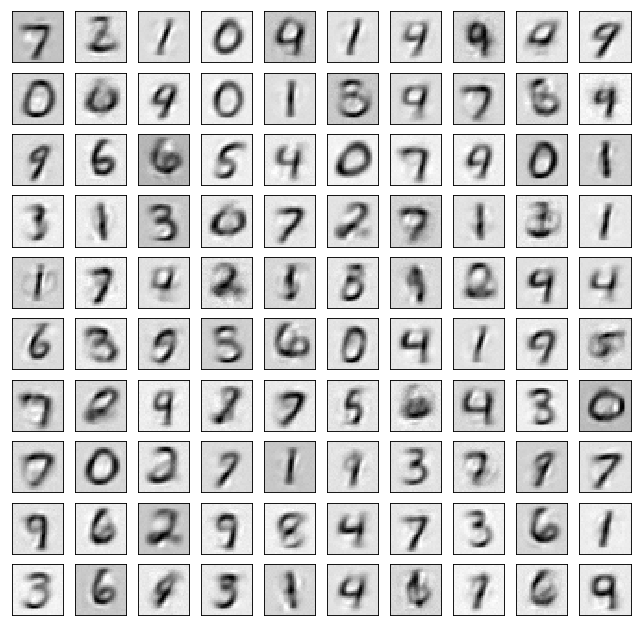

Test losses. VAE32: 128570.7109
Train Epoch: 11 [0/50000 (0%)]	Losses VAE32: 128191.9141
Train Epoch: 11 [25000/50000 (50%)]	Losses VAE32: 128450.1484
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE32: 128058.4844
Test losses. VAE32: 128532.2879
Train Epoch: 12 [0/50000 (0%)]	Losses VAE32: 128545.9297
Train Epoch: 12 [25000/50000 (50%)]	Losses VAE32: 128631.3359
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE32: 128326.5078
Test losses. VAE32: 128484.2312
Train Epoch: 13 [0/50000 (0%)]	Losses VAE32: 128596.5703
Train Epoch: 13 [25000/50000 (50%)]	Losses VAE32: 128370.8828
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE32: 128162.0547
Test losses. VAE32: 128454.1805
Train Epoch: 14 [0/50000 (0%)]	Losses VAE32: 128646.3750
Train Epoch: 14 [25000/50000 (50%)]	Losses VAE32: 128276.0078
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE32: 128338.2891
Test losses. VAE32: 128415.6477
Train Epoch: 15 [0/50000 (0%)]	Losses VAE32: 128432.8516
Train Epoch: 15 [25000/50000 (50%)]	Losses VAE32: 12795

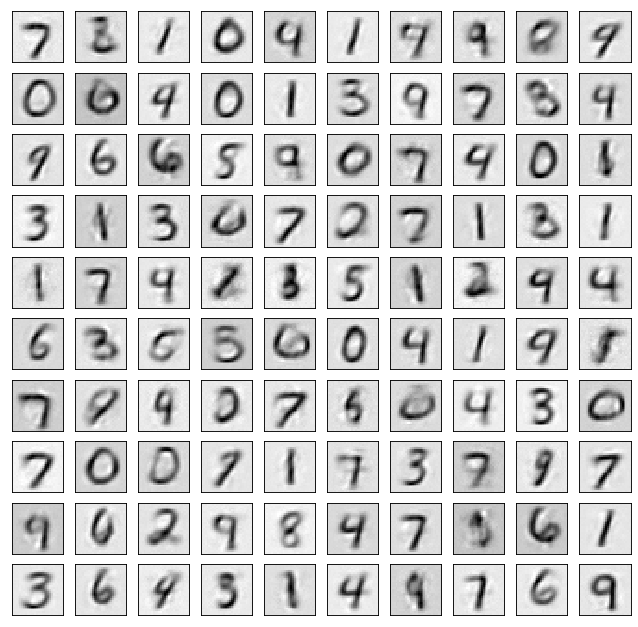

Test losses. VAE32: 128255.4053
Train Epoch: 21 [0/50000 (0%)]	Losses VAE32: 128198.9453
Train Epoch: 21 [25000/50000 (50%)]	Losses VAE32: 128141.7031
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE32: 128113.2109
Test losses. VAE32: 128231.3973
Train Epoch: 22 [0/50000 (0%)]	Losses VAE32: 128140.8672
Train Epoch: 22 [25000/50000 (50%)]	Losses VAE32: 127995.4922
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE32: 128237.8906
Test losses. VAE32: 128228.4162
Train Epoch: 23 [0/50000 (0%)]	Losses VAE32: 128240.0391
Train Epoch: 23 [25000/50000 (50%)]	Losses VAE32: 128143.5859
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE32: 128016.3281
Test losses. VAE32: 128209.3418
Train Epoch: 24 [0/50000 (0%)]	Losses VAE32: 128138.4062
Train Epoch: 24 [25000/50000 (50%)]	Losses VAE32: 128287.1484
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE32: 128395.5781
Test losses. VAE32: 128192.2061
Train Epoch: 25 [0/50000 (0%)]	Losses VAE32: 128403.1250
Train Epoch: 25 [25000/50000 (50%)]	Losses VAE32: 12820

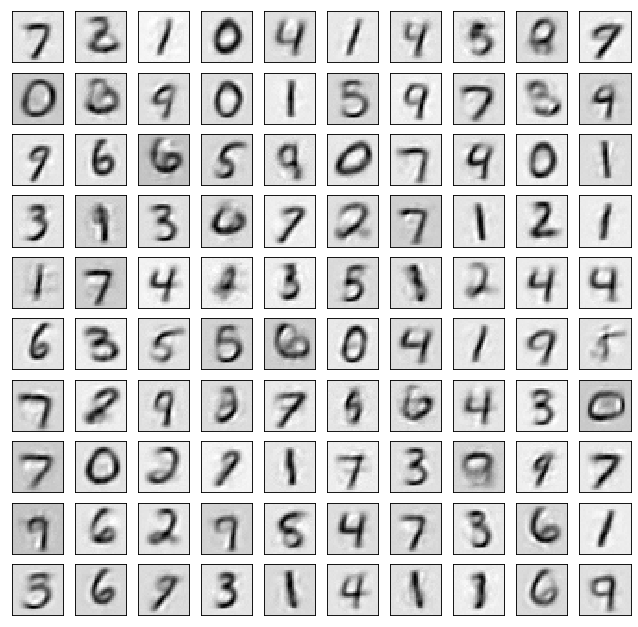

Test losses. VAE32: 128088.2213
Train Epoch: 31 [0/50000 (0%)]	Losses VAE32: 127876.7969
Train Epoch: 31 [25000/50000 (50%)]	Losses VAE32: 128476.3516
Train Epoch: 31 [50000/50000 (100%)]	Losses VAE32: 128330.1641
Test losses. VAE32: 128084.4834
Train Epoch: 32 [0/50000 (0%)]	Losses VAE32: 127992.6250
Train Epoch: 39 [25000/50000 (50%)]	Losses VAE32: 127759.4844
Train Epoch: 39 [50000/50000 (100%)]	Losses VAE32: 127962.7031
Test losses. VAE32: 127997.5682
Train Epoch: 40 [0/50000 (0%)]	Losses VAE32: 127851.9453
Train Epoch: 40 [25000/50000 (50%)]	Losses VAE32: 127895.9453
Train Epoch: 40 [50000/50000 (100%)]	Losses VAE32: 127556.5312


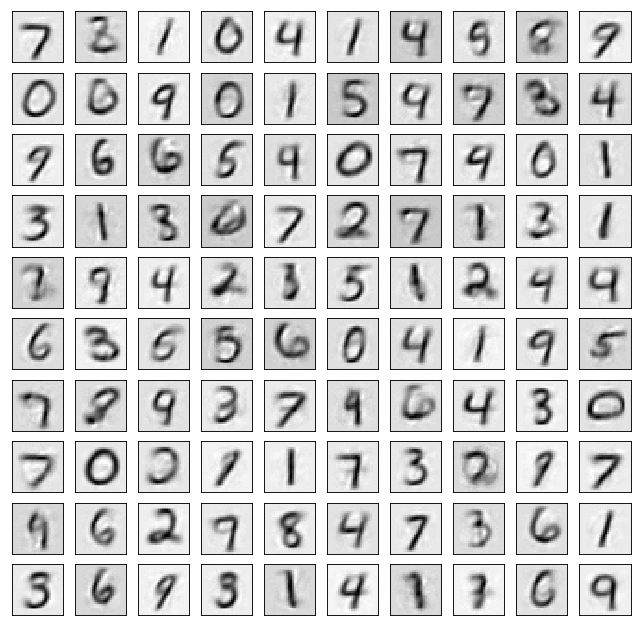

Test losses. VAE32: 127993.0297
Train Epoch: 41 [0/50000 (0%)]	Losses VAE32: 128150.0625
Train Epoch: 41 [25000/50000 (50%)]	Losses VAE32: 127620.7656
Train Epoch: 41 [50000/50000 (100%)]	Losses VAE32: 127668.6406
Test losses. VAE32: 127978.8910
Train Epoch: 42 [0/50000 (0%)]	Losses VAE32: 128020.9297
Train Epoch: 42 [25000/50000 (50%)]	Losses VAE32: 127683.3438
Train Epoch: 42 [50000/50000 (100%)]	Losses VAE32: 127790.4531
Test losses. VAE32: 127972.4477
Train Epoch: 43 [0/50000 (0%)]	Losses VAE32: 127873.9375
Train Epoch: 43 [25000/50000 (50%)]	Losses VAE32: 127955.7422
Train Epoch: 43 [50000/50000 (100%)]	Losses VAE32: 127898.0547
Test losses. VAE32: 127959.6732
Train Epoch: 44 [0/50000 (0%)]	Losses VAE32: 127928.3359
Train Epoch: 44 [25000/50000 (50%)]	Losses VAE32: 127999.5781
Train Epoch: 44 [50000/50000 (100%)]	Losses VAE32: 128099.4297
Test losses. VAE32: 127954.5297
Train Epoch: 45 [0/50000 (0%)]	Losses VAE32: 127994.4688
Train Epoch: 45 [25000/50000 (50%)]	Losses VAE32: 12766

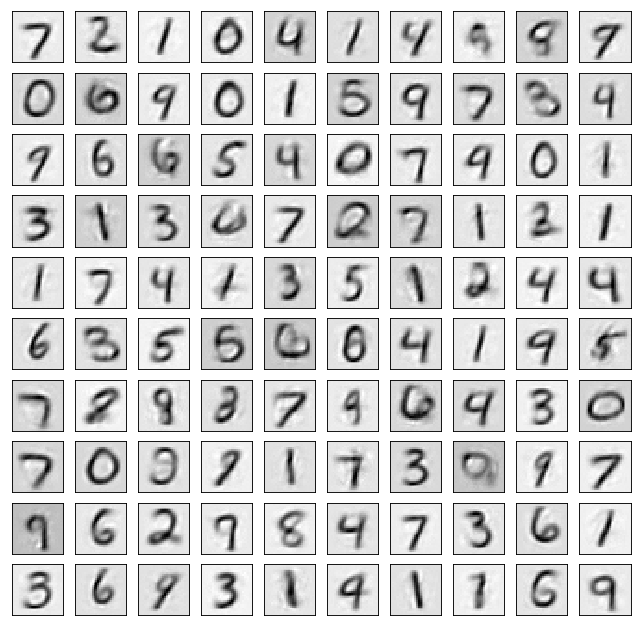

Test losses. VAE32: 127915.0744
Train Epoch: 51 [0/50000 (0%)]	Losses VAE32: 127958.7422
Train Epoch: 51 [25000/50000 (50%)]	Losses VAE32: 127920.4141
Train Epoch: 51 [50000/50000 (100%)]	Losses VAE32: 128059.9844
Test losses. VAE32: 127906.0969
Train Epoch: 52 [0/50000 (0%)]	Losses VAE32: 127722.4062
Train Epoch: 52 [25000/50000 (50%)]	Losses VAE32: 127612.2891
Train Epoch: 52 [50000/50000 (100%)]	Losses VAE32: 128042.1250
Test losses. VAE32: 127901.8729
Train Epoch: 53 [0/50000 (0%)]	Losses VAE32: 128041.9688
Train Epoch: 53 [25000/50000 (50%)]	Losses VAE32: 128095.1562
Train Epoch: 53 [50000/50000 (100%)]	Losses VAE32: 127680.7891
Test losses. VAE32: 127892.5307
Train Epoch: 54 [0/50000 (0%)]	Losses VAE32: 127691.0547
Train Epoch: 54 [25000/50000 (50%)]	Losses VAE32: 128033.6953
Train Epoch: 54 [50000/50000 (100%)]	Losses VAE32: 128075.1953
Test losses. VAE32: 127888.9457
Train Epoch: 55 [0/50000 (0%)]	Losses VAE32: 127526.8750
Train Epoch: 55 [25000/50000 (50%)]	Losses VAE32: 12767

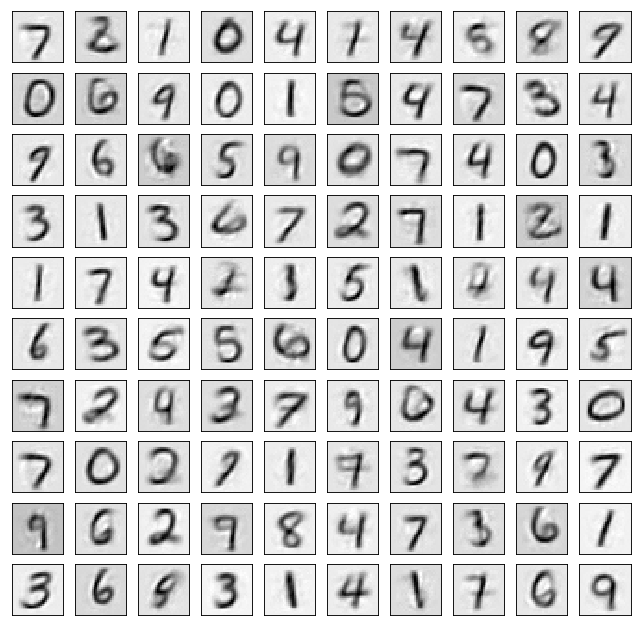

Test losses. VAE32: 127852.2352
Train Epoch: 61 [0/50000 (0%)]	Losses VAE32: 128093.3828
Train Epoch: 61 [25000/50000 (50%)]	Losses VAE32: 127590.0781
Train Epoch: 61 [50000/50000 (100%)]	Losses VAE32: 127952.7188
Test losses. VAE32: 127835.6664
Train Epoch: 62 [0/50000 (0%)]	Losses VAE32: 127806.1953
Train Epoch: 62 [25000/50000 (50%)]	Losses VAE32: 128038.7969
Train Epoch: 62 [50000/50000 (100%)]	Losses VAE32: 127560.5547
Test losses. VAE32: 127831.8193
Train Epoch: 63 [0/50000 (0%)]	Losses VAE32: 127888.3672
Train Epoch: 63 [25000/50000 (50%)]	Losses VAE32: 127799.3672
Train Epoch: 63 [50000/50000 (100%)]	Losses VAE32: 127697.1406
Test losses. VAE32: 127844.0037
Train Epoch: 64 [0/50000 (0%)]	Losses VAE32: 127803.5391
Train Epoch: 64 [25000/50000 (50%)]	Losses VAE32: 127886.1016
Train Epoch: 64 [50000/50000 (100%)]	Losses VAE32: 127799.4297
Test losses. VAE32: 127822.0658
Train Epoch: 65 [0/50000 (0%)]	Losses VAE32: 127907.7266
Train Epoch: 65 [25000/50000 (50%)]	Losses VAE32: 12776

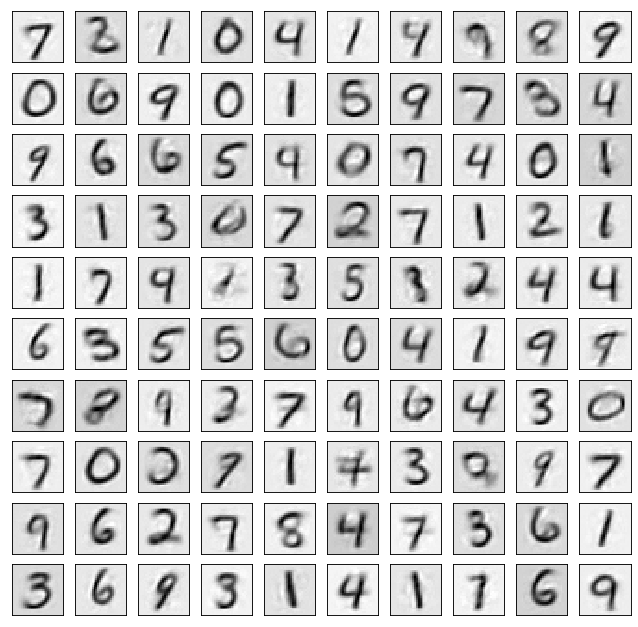

Test losses. VAE32: 127807.0127
Train Epoch: 71 [0/50000 (0%)]	Losses VAE32: 127991.8984
Train Epoch: 71 [25000/50000 (50%)]	Losses VAE32: 127759.3984
Train Epoch: 71 [50000/50000 (100%)]	Losses VAE32: 127824.9844
Test losses. VAE32: 127787.5549
Train Epoch: 72 [0/50000 (0%)]	Losses VAE32: 127403.2578
Train Epoch: 72 [25000/50000 (50%)]	Losses VAE32: 127703.0938
Train Epoch: 72 [50000/50000 (100%)]	Losses VAE32: 128088.5938
Test losses. VAE32: 127809.0832
Train Epoch: 73 [0/50000 (0%)]	Losses VAE32: 128136.8359
Train Epoch: 73 [25000/50000 (50%)]	Losses VAE32: 127799.0938
Train Epoch: 73 [50000/50000 (100%)]	Losses VAE32: 127971.0078
Test losses. VAE32: 127792.8713
Train Epoch: 74 [0/50000 (0%)]	Losses VAE32: 127576.6250
Train Epoch: 74 [25000/50000 (50%)]	Losses VAE32: 128079.1172
Train Epoch: 74 [50000/50000 (100%)]	Losses VAE32: 127811.1250
Test losses. VAE32: 127790.7766
Train Epoch: 75 [0/50000 (0%)]	Losses VAE32: 127759.4453
Train Epoch: 75 [25000/50000 (50%)]	Losses VAE32: 12775

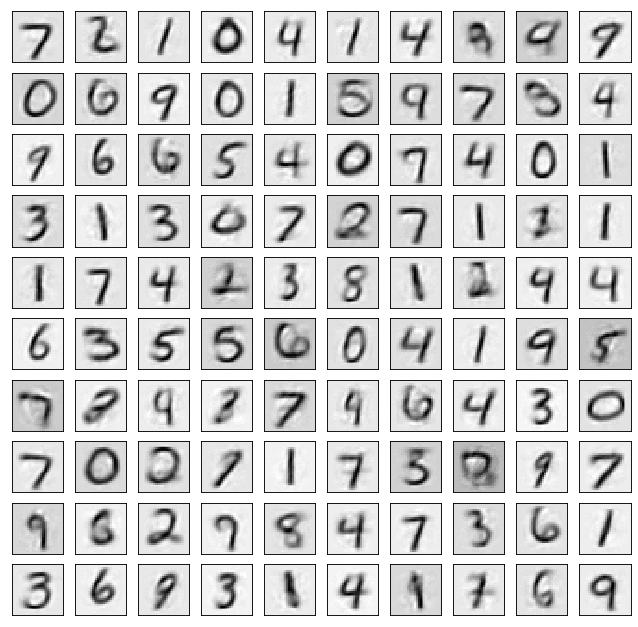

Test losses. VAE32: 127762.3551
Train Epoch: 81 [0/50000 (0%)]	Losses VAE32: 127876.1562
Train Epoch: 81 [25000/50000 (50%)]	Losses VAE32: 127505.1719
Train Epoch: 81 [50000/50000 (100%)]	Losses VAE32: 127887.9141
Test losses. VAE32: 127752.1293
Train Epoch: 82 [0/50000 (0%)]	Losses VAE32: 127432.4453
Train Epoch: 82 [25000/50000 (50%)]	Losses VAE32: 127694.8203
Train Epoch: 82 [50000/50000 (100%)]	Losses VAE32: 127488.3203
Test losses. VAE32: 127758.2674
Train Epoch: 83 [0/50000 (0%)]	Losses VAE32: 127888.7422
Train Epoch: 83 [25000/50000 (50%)]	Losses VAE32: 127826.1406
Train Epoch: 83 [50000/50000 (100%)]	Losses VAE32: 127960.3516
Test losses. VAE32: 127759.6293
Train Epoch: 84 [0/50000 (0%)]	Losses VAE32: 127900.4844
Train Epoch: 84 [25000/50000 (50%)]	Losses VAE32: 127574.7109
Train Epoch: 84 [50000/50000 (100%)]	Losses VAE32: 127693.3281
Test losses. VAE32: 127760.3721
Train Epoch: 85 [0/50000 (0%)]	Losses VAE32: 127614.5391
Train Epoch: 85 [25000/50000 (50%)]	Losses VAE32: 12781

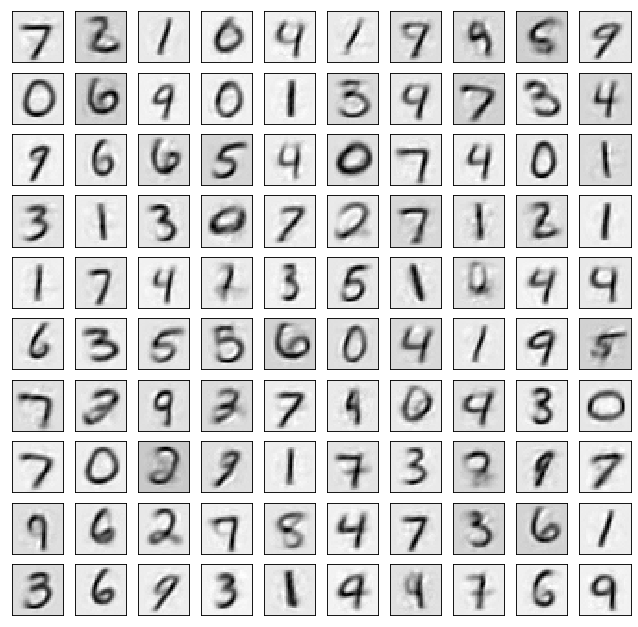

Test losses. VAE32: 127722.7533
Train Epoch: 91 [0/50000 (0%)]	Losses VAE32: 127856.6250
Train Epoch: 91 [25000/50000 (50%)]	Losses VAE32: 128031.4141
Train Epoch: 91 [50000/50000 (100%)]	Losses VAE32: 127860.5938
Test losses. VAE32: 127718.8031
Train Epoch: 92 [0/50000 (0%)]	Losses VAE32: 127521.3672
Train Epoch: 92 [25000/50000 (50%)]	Losses VAE32: 127784.7188
Train Epoch: 92 [50000/50000 (100%)]	Losses VAE32: 126988.8438
Test losses. VAE32: 127727.6504
Train Epoch: 93 [0/50000 (0%)]	Losses VAE32: 127586.9219
Train Epoch: 93 [25000/50000 (50%)]	Losses VAE32: 127542.6328
Train Epoch: 93 [50000/50000 (100%)]	Losses VAE32: 127208.9844
Test losses. VAE32: 127712.6564
Train Epoch: 94 [0/50000 (0%)]	Losses VAE32: 127439.6484
Train Epoch: 94 [25000/50000 (50%)]	Losses VAE32: 127474.8281
Train Epoch: 94 [50000/50000 (100%)]	Losses VAE32: 127870.5781
Test losses. VAE32: 127723.2025
Train Epoch: 95 [0/50000 (0%)]	Losses VAE32: 127538.3125
Train Epoch: 95 [25000/50000 (50%)]	Losses VAE32: 12743

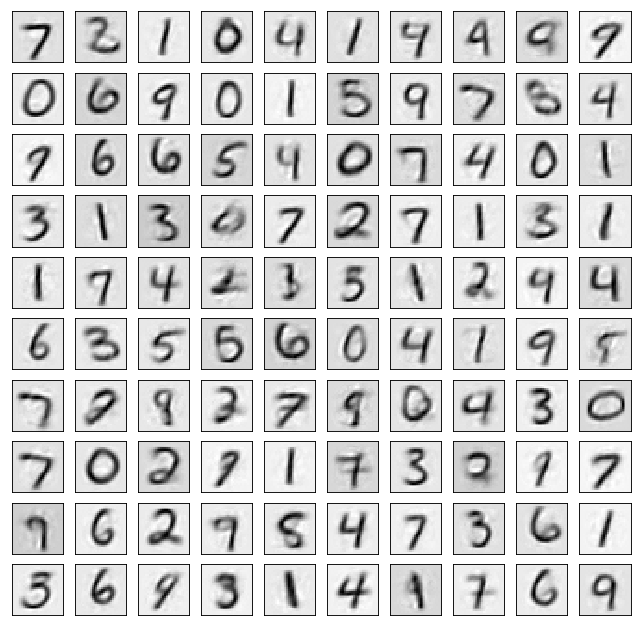

Test losses. VAE32: 127692.4377
Train Epoch: 1 [0/50000 (0%)]	Losses VAE64: 136308.2500
Train Epoch: 1 [25000/50000 (50%)]	Losses VAE64: 131772.7500
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE64: 130984.6875
Test losses. VAE64: 131061.3174
Train Epoch: 2 [0/50000 (0%)]	Losses VAE64: 131068.2266
Train Epoch: 2 [25000/50000 (50%)]	Losses VAE64: 130437.2344
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE64: 130252.7734
Test losses. VAE64: 130335.2143
Train Epoch: 3 [0/50000 (0%)]	Losses VAE64: 130606.7266
Train Epoch: 3 [25000/50000 (50%)]	Losses VAE64: 130216.5547
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE64: 129824.1562
Test losses. VAE64: 129861.4410
Train Epoch: 4 [0/50000 (0%)]	Losses VAE64: 129866.2109
Train Epoch: 4 [25000/50000 (50%)]	Losses VAE64: 129484.6953
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE64: 129366.8906
Test losses. VAE64: 129505.0813
Train Epoch: 5 [0/50000 (0%)]	Losses VAE64: 129534.3281
Train Epoch: 5 [25000/50000 (50%)]	Losses VAE64: 129494.8438
Train E

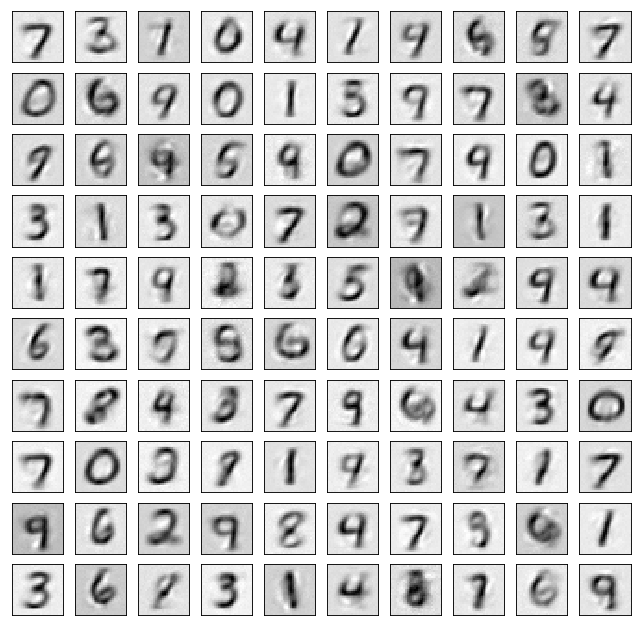

Test losses. VAE64: 128679.8336
Train Epoch: 11 [0/50000 (0%)]	Losses VAE64: 128538.9609
Train Epoch: 11 [25000/50000 (50%)]	Losses VAE64: 128428.3984
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE64: 128436.6797
Test losses. VAE64: 128623.3428
Train Epoch: 12 [0/50000 (0%)]	Losses VAE64: 128244.5469
Train Epoch: 12 [25000/50000 (50%)]	Losses VAE64: 129017.3047
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE64: 128340.6484
Test losses. VAE64: 128588.6359
Train Epoch: 13 [0/50000 (0%)]	Losses VAE64: 128500.5625
Train Epoch: 13 [25000/50000 (50%)]	Losses VAE64: 128692.1406
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE64: 128691.6875
Test losses. VAE64: 128531.7254
Train Epoch: 14 [0/50000 (0%)]	Losses VAE64: 128726.4297
Train Epoch: 14 [25000/50000 (50%)]	Losses VAE64: 128400.8359
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE64: 127929.5938
Test losses. VAE64: 128501.0723
Train Epoch: 15 [0/50000 (0%)]	Losses VAE64: 127974.7656
Train Epoch: 15 [25000/50000 (50%)]	Losses VAE64: 12847

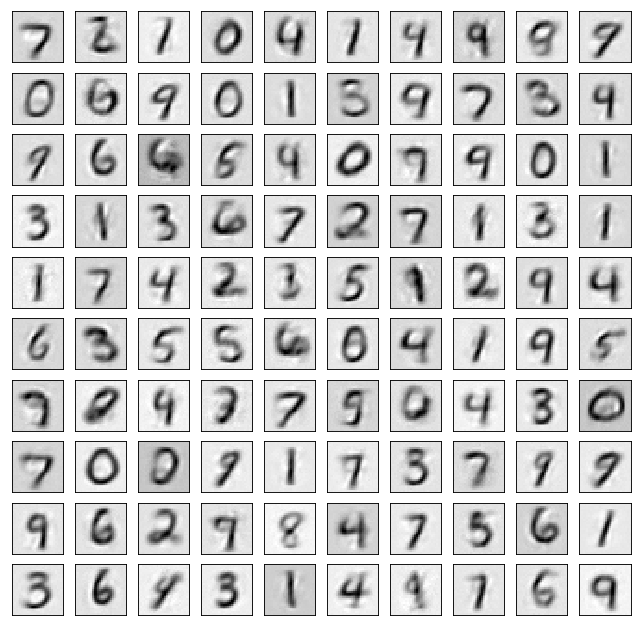

Test losses. VAE64: 128332.4154
Train Epoch: 21 [0/50000 (0%)]	Losses VAE64: 128402.8125
Train Epoch: 21 [25000/50000 (50%)]	Losses VAE64: 128189.4062
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE64: 128272.3594
Test losses. VAE64: 128304.4998
Train Epoch: 22 [0/50000 (0%)]	Losses VAE64: 128162.2578
Train Epoch: 22 [25000/50000 (50%)]	Losses VAE64: 128623.9453
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE64: 128574.5000
Test losses. VAE64: 128277.9160
Train Epoch: 23 [0/50000 (0%)]	Losses VAE64: 128364.4531
Train Epoch: 23 [25000/50000 (50%)]	Losses VAE64: 128359.7500
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE64: 128279.5547
Test losses. VAE64: 128250.6699
Train Epoch: 24 [0/50000 (0%)]	Losses VAE64: 128217.7109
Train Epoch: 24 [25000/50000 (50%)]	Losses VAE64: 127960.5078
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE64: 128531.6641
Test losses. VAE64: 128227.4926
Train Epoch: 25 [0/50000 (0%)]	Losses VAE64: 128263.8906
Train Epoch: 25 [25000/50000 (50%)]	Losses VAE64: 12806

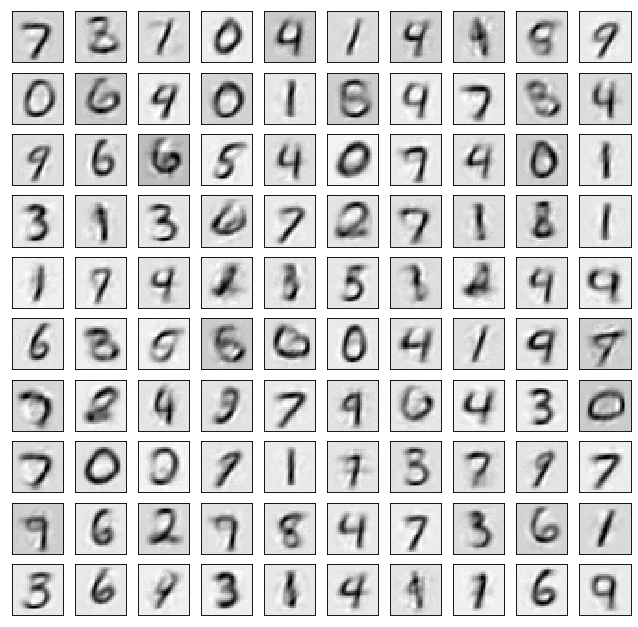

Test losses. VAE64: 128140.7473
Train Epoch: 31 [0/50000 (0%)]	Losses VAE64: 128089.6875
Train Epoch: 31 [25000/50000 (50%)]	Losses VAE64: 128085.6094
Train Epoch: 31 [50000/50000 (100%)]	Losses VAE64: 127957.9297
Test losses. VAE64: 128124.3332
Train Epoch: 32 [0/50000 (0%)]	Losses VAE64: 127998.6328
Train Epoch: 32 [25000/50000 (50%)]	Losses VAE64: 128276.0938
Train Epoch: 32 [50000/50000 (100%)]	Losses VAE64: 128077.8281
Test losses. VAE64: 128118.5396
Train Epoch: 33 [0/50000 (0%)]	Losses VAE64: 127955.9062
Train Epoch: 33 [25000/50000 (50%)]	Losses VAE64: 128021.7500
Train Epoch: 33 [50000/50000 (100%)]	Losses VAE64: 127778.5078
Test losses. VAE64: 128099.1129
Train Epoch: 34 [0/50000 (0%)]	Losses VAE64: 128001.7891
Train Epoch: 34 [25000/50000 (50%)]	Losses VAE64: 128075.1172
Train Epoch: 34 [50000/50000 (100%)]	Losses VAE64: 128170.6328
Test losses. VAE64: 128083.7904
Train Epoch: 35 [0/50000 (0%)]	Losses VAE64: 127632.7109
Train Epoch: 35 [25000/50000 (50%)]	Losses VAE64: 12790

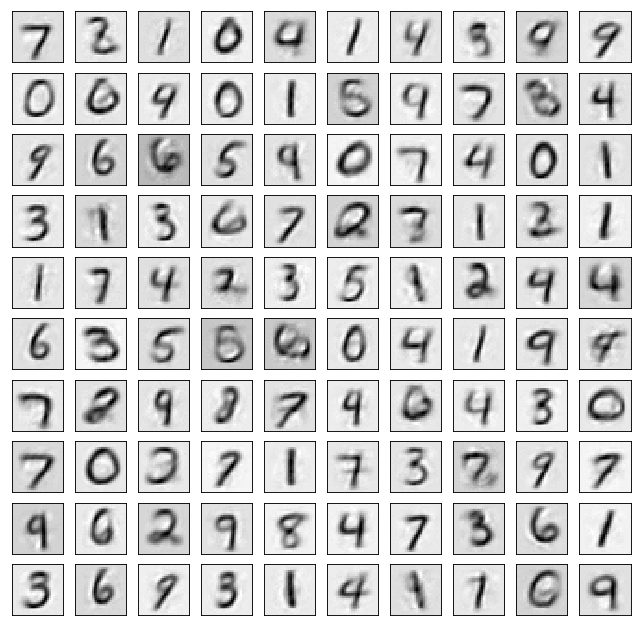

Test losses. VAE64: 128029.5344
Train Epoch: 41 [0/50000 (0%)]	Losses VAE64: 128071.0469
Train Epoch: 41 [25000/50000 (50%)]	Losses VAE64: 127832.5859
Train Epoch: 41 [50000/50000 (100%)]	Losses VAE64: 127952.4844
Test losses. VAE64: 128012.7713
Train Epoch: 42 [0/50000 (0%)]	Losses VAE64: 128059.3594
Train Epoch: 42 [25000/50000 (50%)]	Losses VAE64: 127870.1016
Train Epoch: 42 [50000/50000 (100%)]	Losses VAE64: 127865.6641
Test losses. VAE64: 127994.9484
Train Epoch: 43 [0/50000 (0%)]	Losses VAE64: 127997.6406
Train Epoch: 43 [25000/50000 (50%)]	Losses VAE64: 127918.4688
Train Epoch: 43 [50000/50000 (100%)]	Losses VAE64: 127475.8438
Test losses. VAE64: 127995.9033
Train Epoch: 44 [0/50000 (0%)]	Losses VAE64: 127785.1406
Train Epoch: 44 [25000/50000 (50%)]	Losses VAE64: 128130.7500
Train Epoch: 44 [50000/50000 (100%)]	Losses VAE64: 127851.1172
Test losses. VAE64: 127988.4207
Train Epoch: 45 [0/50000 (0%)]	Losses VAE64: 127901.2578
Train Epoch: 45 [25000/50000 (50%)]	Losses VAE64: 12837

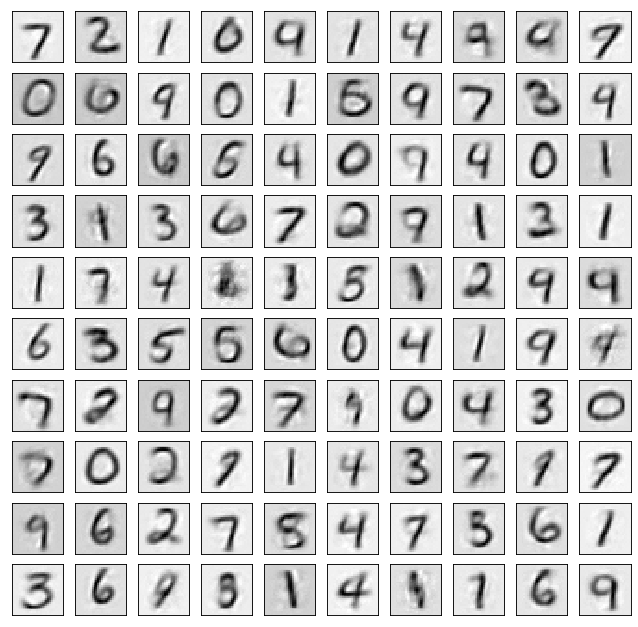

Test losses. VAE64: 127948.8861
Train Epoch: 51 [0/50000 (0%)]	Losses VAE64: 127522.9062
Train Epoch: 51 [25000/50000 (50%)]	Losses VAE64: 128160.3672
Train Epoch: 51 [50000/50000 (100%)]	Losses VAE64: 127957.5234
Test losses. VAE64: 127930.5430
Train Epoch: 52 [0/50000 (0%)]	Losses VAE64: 127797.2031
Train Epoch: 52 [25000/50000 (50%)]	Losses VAE64: 127795.6172
Train Epoch: 52 [50000/50000 (100%)]	Losses VAE64: 128028.1172
Test losses. VAE64: 127921.7820
Train Epoch: 53 [0/50000 (0%)]	Losses VAE64: 127922.8438
Train Epoch: 53 [25000/50000 (50%)]	Losses VAE64: 127569.5781
Train Epoch: 53 [50000/50000 (100%)]	Losses VAE64: 127466.5547
Test losses. VAE64: 127920.1881
Train Epoch: 54 [0/50000 (0%)]	Losses VAE64: 128068.3047
Train Epoch: 54 [25000/50000 (50%)]	Losses VAE64: 127849.2109
Train Epoch: 54 [50000/50000 (100%)]	Losses VAE64: 127877.9297
Test losses. VAE64: 127915.9654
Train Epoch: 55 [0/50000 (0%)]	Losses VAE64: 127741.9219
Train Epoch: 55 [25000/50000 (50%)]	Losses VAE64: 12778

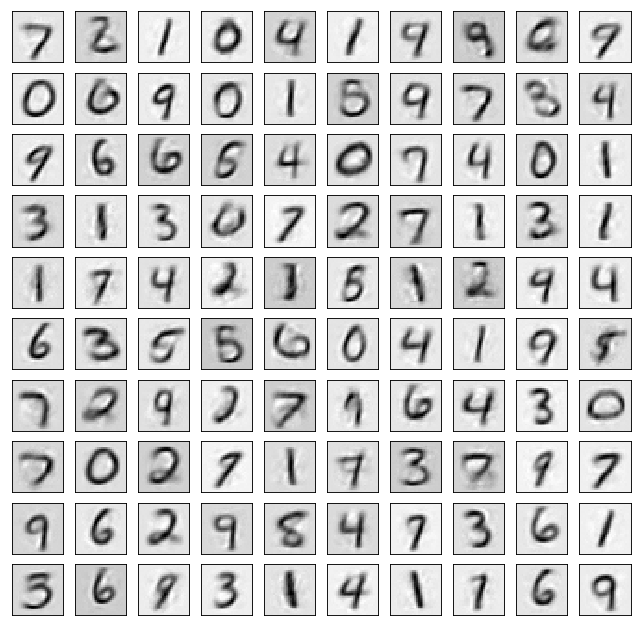

Test losses. VAE64: 127883.8049
Train Epoch: 61 [0/50000 (0%)]	Losses VAE64: 127476.1953
Train Epoch: 61 [25000/50000 (50%)]	Losses VAE64: 127728.1641
Train Epoch: 61 [50000/50000 (100%)]	Losses VAE64: 127925.8047
Test losses. VAE64: 127876.2305
Train Epoch: 62 [0/50000 (0%)]	Losses VAE64: 128132.3672
Train Epoch: 62 [25000/50000 (50%)]	Losses VAE64: 127938.8125
Train Epoch: 62 [50000/50000 (100%)]	Losses VAE64: 127953.1797
Test losses. VAE64: 127864.4803
Train Epoch: 63 [0/50000 (0%)]	Losses VAE64: 127526.3047
Train Epoch: 63 [25000/50000 (50%)]	Losses VAE64: 127958.1484
Train Epoch: 63 [50000/50000 (100%)]	Losses VAE64: 127484.9766
Test losses. VAE64: 127868.2129
Train Epoch: 64 [0/50000 (0%)]	Losses VAE64: 127720.5938
Train Epoch: 64 [25000/50000 (50%)]	Losses VAE64: 127667.9844
Train Epoch: 64 [50000/50000 (100%)]	Losses VAE64: 127952.2266
Test losses. VAE64: 127864.3547
Train Epoch: 65 [0/50000 (0%)]	Losses VAE64: 127926.9609
Train Epoch: 65 [25000/50000 (50%)]	Losses VAE64: 12793

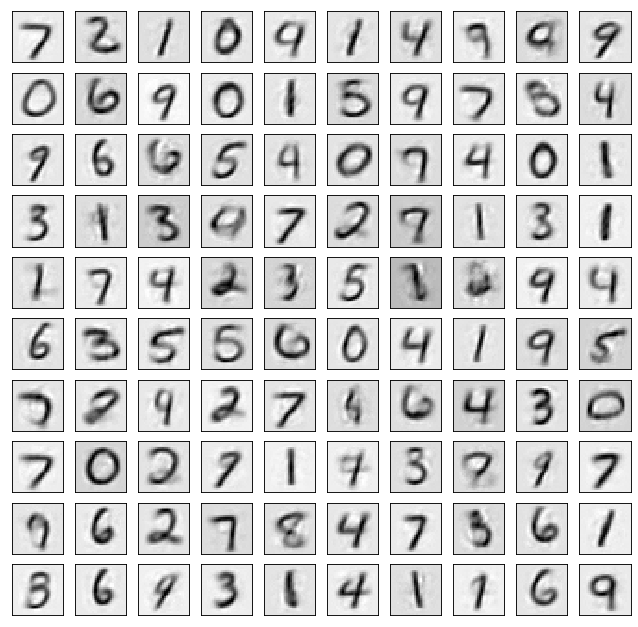

Test losses. VAE64: 127835.0014
Train Epoch: 71 [0/50000 (0%)]	Losses VAE64: 127709.0938
Train Epoch: 71 [25000/50000 (50%)]	Losses VAE64: 127762.4688
Train Epoch: 71 [50000/50000 (100%)]	Losses VAE64: 127706.5234
Test losses. VAE64: 127826.3164
Train Epoch: 72 [0/50000 (0%)]	Losses VAE64: 127879.8594
Train Epoch: 72 [25000/50000 (50%)]	Losses VAE64: 127834.9219
Train Epoch: 72 [50000/50000 (100%)]	Losses VAE64: 127656.3984
Test losses. VAE64: 127816.6613
Train Epoch: 73 [0/50000 (0%)]	Losses VAE64: 128033.7734
Train Epoch: 73 [25000/50000 (50%)]	Losses VAE64: 127402.1875
Train Epoch: 73 [50000/50000 (100%)]	Losses VAE64: 128019.0781
Test losses. VAE64: 127815.0176
Train Epoch: 74 [0/50000 (0%)]	Losses VAE64: 127763.2969
Train Epoch: 74 [25000/50000 (50%)]	Losses VAE64: 127682.1406
Train Epoch: 74 [50000/50000 (100%)]	Losses VAE64: 127356.2188
Test losses. VAE64: 127799.8385
Train Epoch: 75 [0/50000 (0%)]	Losses VAE64: 127563.8359
Train Epoch: 75 [25000/50000 (50%)]	Losses VAE64: 12756

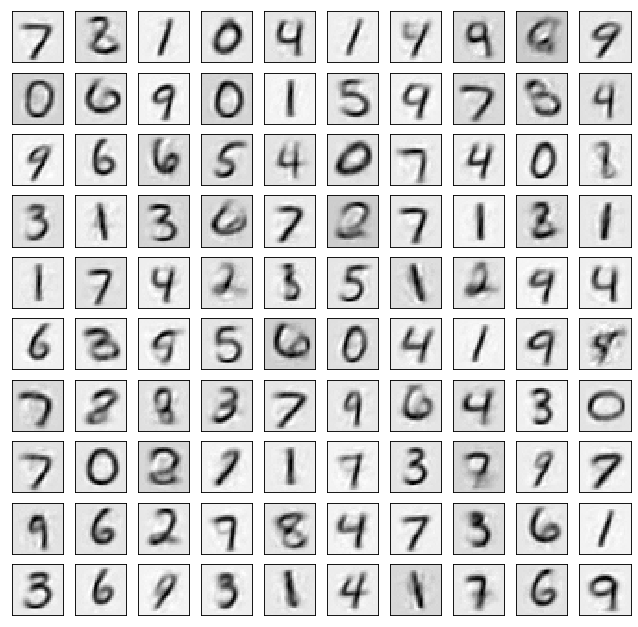

Test losses. VAE64: 127791.8941
Train Epoch: 81 [0/50000 (0%)]	Losses VAE64: 127893.3359
Train Epoch: 81 [25000/50000 (50%)]	Losses VAE64: 127788.2266
Train Epoch: 81 [50000/50000 (100%)]	Losses VAE64: 127932.7422
Test losses. VAE64: 127771.8932
Train Epoch: 82 [0/50000 (0%)]	Losses VAE64: 127769.3516
Train Epoch: 82 [25000/50000 (50%)]	Losses VAE64: 127642.1484
Train Epoch: 82 [50000/50000 (100%)]	Losses VAE64: 128020.3516
Test losses. VAE64: 127780.9719
Train Epoch: 83 [0/50000 (0%)]	Losses VAE64: 127801.4141
Train Epoch: 83 [25000/50000 (50%)]	Losses VAE64: 127619.6094
Train Epoch: 83 [50000/50000 (100%)]	Losses VAE64: 127885.3125
Test losses. VAE64: 127781.4740
Train Epoch: 84 [0/50000 (0%)]	Losses VAE64: 128103.0312
Train Epoch: 84 [25000/50000 (50%)]	Losses VAE64: 127379.7188
Train Epoch: 84 [50000/50000 (100%)]	Losses VAE64: 127422.6094
Test losses. VAE64: 127785.0129
Train Epoch: 85 [0/50000 (0%)]	Losses VAE64: 128111.2422
Train Epoch: 85 [25000/50000 (50%)]	Losses VAE64: 12757

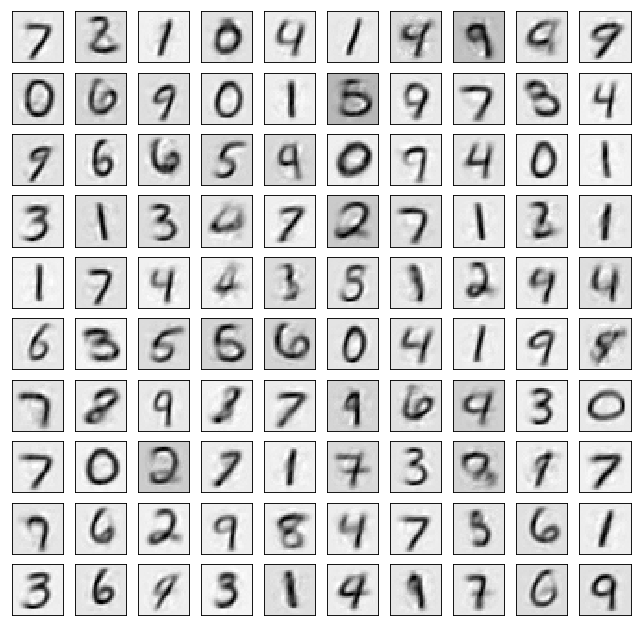

Test losses. VAE64: 127748.1535
Train Epoch: 91 [0/50000 (0%)]	Losses VAE64: 127663.3516
Train Epoch: 91 [25000/50000 (50%)]	Losses VAE64: 127774.4922
Train Epoch: 91 [50000/50000 (100%)]	Losses VAE64: 127765.2891
Test losses. VAE64: 127744.2176
Train Epoch: 92 [0/50000 (0%)]	Losses VAE64: 127526.8516
Train Epoch: 92 [25000/50000 (50%)]	Losses VAE64: 127726.4062
Train Epoch: 92 [50000/50000 (100%)]	Losses VAE64: 127720.1328
Test losses. VAE64: 127739.1346
Train Epoch: 93 [0/50000 (0%)]	Losses VAE64: 127735.8438
Train Epoch: 93 [25000/50000 (50%)]	Losses VAE64: 127699.8438
Train Epoch: 93 [50000/50000 (100%)]	Losses VAE64: 127805.9922
Test losses. VAE64: 127742.3643
Train Epoch: 94 [0/50000 (0%)]	Losses VAE64: 127667.9922
Train Epoch: 94 [25000/50000 (50%)]	Losses VAE64: 127384.1797
Train Epoch: 94 [50000/50000 (100%)]	Losses VAE64: 127389.9766
Test losses. VAE64: 127738.4430
Train Epoch: 95 [0/50000 (0%)]	Losses VAE64: 127547.6484
Train Epoch: 95 [25000/50000 (50%)]	Losses VAE64: 12753

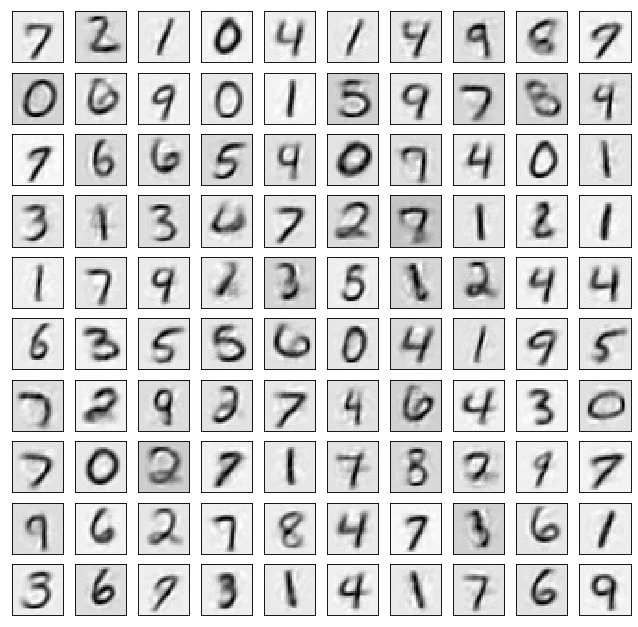

Test losses. VAE64: 127722.1893


In [100]:
for name, model in models.items():
    full_recon_folder = recon_folder + name + '/'
    if not os.path.isdir(full_recon_folder):
        os.mkdir(full_recon_folder)
        
    for epoch in range(1, 101):
        model.train()
        train(model, epoch, train_log)
        model.eval()
        test(model, valid_loader, epoch, full_recon_folder, test_log)

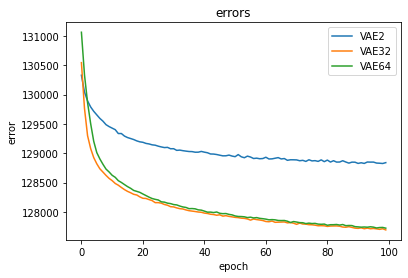

In [101]:
plot_graphs(test_log, 'loss')

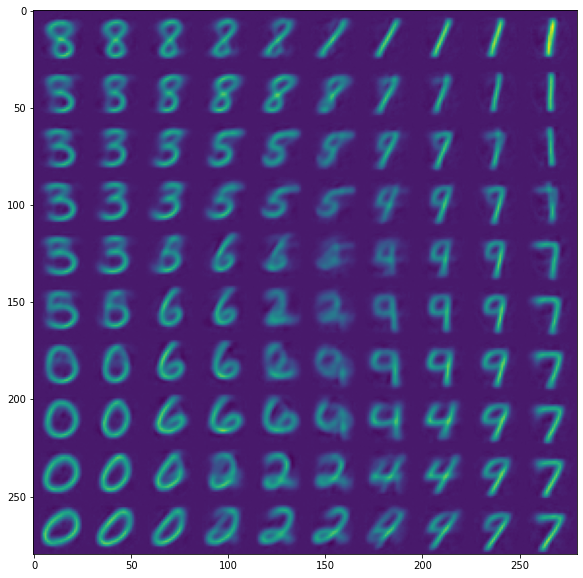

In [102]:
from scipy.stats import norm

n = 10  # 10x10 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        z_sample = torch.Tensor(z_sample).to(device)
        x_decoded = models['VAE2'].decoder(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.detach().cpu()

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()